```python
import yfinance as yf

# Fetch historical data for the S&P 500 index
sp500 = yf.Ticker("^GSPC")
data = sp500.history(period="max")
#data.to_csv("sp500_data.csv")

nasdaq = yf.Ticker("^NDX")
nasdaq_data = nasdaq.history(period="max")
nasdaq_data.to_csv("nasdaq100_data.csv")

dowjones = yf.Ticker("^DJI")
dowjones_data = dowjones.history(period="max")
dowjones_data.to_csv("dowjones_data.csv")
```

In [1]:
def set_seed(seed=42):
    import torch
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42) 

In [2]:
import pandas as pd

data_name = "nasdaq"

# Load the data from the CSV file
data = pd.read_csv("nasdaq100_data.csv", index_col='Date', parse_dates=True)
data.index = pd.to_datetime(data.index, utc=True)  # Ensure timezone-aware objects are converted to UTC
data.index = data.index.tz_convert(None)  # Remove timezone information
# Verify the loaded data
#print(data.head())

data['Return'] = data['Close'].pct_change()
data['Return_Squared'] = data['Return'] ** 2
data['Positive_Return'] = (data['Return'] > 0).astype(int)
data['Return_Squared_Positive'] = data['Return_Squared'] * data['Positive_Return']

start_date = pd.Timestamp("2000-02-29")
end_date = pd.Timestamp("2020-02-28")
filtered_data = data.loc[start_date:end_date]
filtered_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_39288\30628000.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)


In [3]:
df_normalized = filtered_data.copy()
columns_to_normalize = filtered_data.columns

for column in columns_to_normalize:
    col_mean = filtered_data[column].mean()
    col_min = filtered_data[column].min()
    col_max = filtered_data[column].max()

    df_normalized[column] = (filtered_data[column] - col_mean) / (col_max - col_min)

In [4]:
import numpy as np

# Use all features, including 'Return_Squared'
features = df_normalized.columns
target = 'Return'

# Create input (x) and label (y)
sequence_length = 20  # Number of days in the input window
X, y = [], []

# Iterate over the data to create sequences
for i in range(len(df_normalized) - sequence_length):
    # Get the input window of 20 rows
    X.append(df_normalized[features].iloc[i:i + sequence_length].values)
    # Get the target (current r^2)
    y.append(filtered_data[target].iloc[i + sequence_length])

# Convert to numpy arrays for model compatibility
X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # Should be (num_samples, 20, n_columns)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (5011, 20, 9)
Shape of y: (5011,)


In [5]:
from sklearn.model_selection import train_test_split

# Determine split index
#train_size = int(0.9 * len(X))
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

# Split the data
#X_train, X_test = X[:train_size], X[train_size:]
#y_train, y_test = y[:train_size], y[train_size:]

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Val set shape:", X_val.shape, y_val.shape)

Training set shape: (4008, 20, 9) (4008,)
Test set shape: (502, 20, 9) (502,)
Val set shape: (501, 20, 9) (501,)


In [6]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return input and target as tensors
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)
    


In [7]:
batch_size = 500

# Create Dataset objects
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

from torch.utils.data import DataLoader

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,generator=torch.Generator().manual_seed(42))  # Shuffle for training
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for testing
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 

print("Number of training batches:", len(train_loader))
print("Number of testing batches:", len(test_loader))
print("Number of val batches:", len(val_loader))

Number of training batches: 9
Number of testing batches: 2
Number of val batches: 2


In [8]:
import torch
import torch.nn as nn

class ANN(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_sizes):
        super(ANN, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)
        
        # Define dense layers
        dense_layers = []
        prev_size = lstm_hidden_size  # Output size of LSTM
        for size in dense_hidden_sizes:
            dense_layers.append(nn.Linear(prev_size, size))
            # Using identity (no activation) based on the paper
            prev_size = size
        dense_layers.append(nn.Linear(prev_size, 1))
            
        self.dense = nn.Sequential(*dense_layers)

        # Final softplus layer for non-negative output
        self.softplus = nn.Softplus()

    def forward(self, x):
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]  # Take the last time step's output
        
        # Pass through dense layers
        dense_out = self.dense(last_hidden_state)
        
        # Apply softplus activation to ensure non-negative output
        output = self.softplus(dense_out)**2
        return output

In [9]:
class ANN_drop_act(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_sizes, dropout_rate=0.0, activation=None):
        """
        Args:
            input_size: Number of input features.
            lstm_hidden_size: Hidden size for LSTM.
            dense_hidden_sizes: List of hidden layer sizes for the dense block.
            dropout_rate: Dropout rate to apply after LSTM and dense layers.
            activation: Activation function (e.g., nn.ReLU, nn.Tanh).
        """
        super(ANN_drop_act,self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)
        self.dropout_lstm = nn.Dropout(dropout_rate)  # Dropout after LSTM

        # Define dense layers
        dense_layers = []
        prev_size = lstm_hidden_size
        for size in dense_hidden_sizes:
            dense_layers.append(nn.Linear(prev_size, size))
            if activation:
                dense_layers.append(activation())  # Activation function
            if dropout_rate > 0:
                dense_layers.append(nn.Dropout(dropout_rate))  # Dropout
            prev_size = size

        # Final layer to output 1 value
        dense_layers.append(nn.Linear(prev_size, 1))
        self.dense = nn.Sequential(*dense_layers)

        # Final softplus layer for non-negative output
        self.softplus = nn.Softplus()

    def forward(self, x):
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]  # Last time step output
        
        # Dropout after LSTM
        lstm_out = self.dropout_lstm(last_hidden_state)
        
        # Pass through dense layers
        dense_out = self.dense(lstm_out)
        
        # Apply softplus activation to ensure non-negative output
        output = self.softplus(dense_out) ** 2
        return output

In [10]:
class ANN_multiplier(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_sizes, dropout_rate=0.0, activation=None):
        """
        Args:
            input_size: Number of input features.
            lstm_hidden_size: Hidden size for LSTM.
            dense_hidden_sizes: List of hidden layer sizes for the dense block.
            dropout_rate: Dropout rate to apply after LSTM and dense layers.
            activation: Activation function (e.g., nn.ReLU, nn.Tanh).
        """
        super(ANN_drop_act,self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True, num_layers=2, dropout=dropout_rate)
        self.dropout_lstm = nn.Dropout(dropout_rate)  # Dropout after LSTM

        # Define dense layers
        dense_layers = []
        prev_size = lstm_hidden_size
        for size in dense_hidden_sizes:
            dense_layers.append(nn.Linear(prev_size, size))
            if activation:
                dense_layers.append(activation())  # Activation function
            if dropout_rate > 0:
                dense_layers.append(nn.Dropout(dropout_rate))  # Dropout
            prev_size = size

        # Final layer to output 1 value
        dense_layers.append(nn.Linear(prev_size, 1))
        self.dense = nn.Sequential(*dense_layers)

        # Final softplus layer for non-negative output
        self.softplus = nn.Softplus()

    def forward(self, x):
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]  # Last time step output
        
        # Dropout after LSTM
        lstm_out = self.dropout_lstm(last_hidden_state)
        
        # Pass through dense layers
        dense_out = self.dense(lstm_out)
        
        # Apply softplus activation to ensure non-negative output
        output = self.softplus(dense_out) ** 2
        return output

In [11]:
class ANN_CNN_LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_sizes, dropout_rate=0.0, activation=None):
        super(ANN_CNN_LSTM, self).__init__()
        # 1D CNN
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # LSTM
        self.lstm = nn.LSTM(16, lstm_hidden_size, batch_first=True)
        self.dropout_lstm = nn.Dropout(dropout_rate)

        # Dense layers
        dense_layers = []
        prev_size = lstm_hidden_size
        for size in dense_hidden_sizes:
            dense_layers.append(nn.Linear(prev_size, size))
            if activation:
                dense_layers.append(activation())
            if dropout_rate > 0:
                dense_layers.append(nn.Dropout(dropout_rate))
            prev_size = size
        dense_layers.append(nn.Linear(prev_size, 1))
        
        self.dense = nn.Sequential(*dense_layers)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to (batch, channels, time_steps) for CNN
        cnn_out = self.pool(torch.relu(self.conv1(x)))
        cnn_out = cnn_out.permute(0, 2, 1)  # Back to (batch, time_steps, channels)

        # LSTM
        lstm_out, _ = self.lstm(cnn_out)
        last_hidden_state = self.dropout_lstm(lstm_out[:, -1, :])

        # Dense layers
        dense_out = self.dense(last_hidden_state)
        output = self.softplus(dense_out) ** 2
        return output

In [12]:
class ANN_Attention(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_sizes, num_heads=1, dropout_rate=0.0, activation=None):
        super(ANN_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=lstm_hidden_size, num_heads=num_heads, dropout=dropout_rate, batch_first=True)
        
        dense_layers = []
        prev_size = lstm_hidden_size
        for size in dense_hidden_sizes:
            dense_layers.append(nn.Linear(prev_size, size))
            if activation:
                dense_layers.append(activation())  # Activation function
            if dropout_rate > 0:
                dense_layers.append(nn.Dropout(dropout_rate))  # Dropout
            prev_size = size
        dense_layers.append(nn.Linear(prev_size, 1))

        self.dense = nn.Sequential(*dense_layers)
        self.softplus = nn.Softplus()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Shape: (batch, time_steps, hidden_size)
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)  # Self-attention on LSTM outputs
        attn_output = attn_output[:, -1, :]  # Use the last time step after attention

        dense_out = self.dense(attn_output)
        output = self.softplus(dense_out) ** 2
        return output

In [13]:
import torch
import torch.nn as nn

class StudentTNegativeLogLikelihood(nn.Module):
    def __init__(self, nu):
        """
        Custom loss function for the Student's t-distribution negative log-likelihood.
        
        Parameters:
            nu (float): Degrees of freedom (must be > 2).
        """
        super(StudentTNegativeLogLikelihood, self).__init__()
        self.nu = nu  # Degrees of freedom (constant for now)
        assert nu > 2, "Degrees of freedom (nu) must be greater than 2."

    def forward(self, r_t, h_t):
        """
        Compute the negative log-likelihood loss.

        Parameters:
            r_t (Tensor): Target returns (batch_size,).
            h_t (Tensor): Predicted conditional variances (batch_size,).

        Returns:
            Tensor: Negative log-likelihood loss.
        """
        # Precompute constants
        log_gamma_nu_plus_1_2 = torch.lgamma(torch.tensor((self.nu + 1) / 2))
        log_gamma_nu_2 = torch.lgamma(torch.tensor(self.nu / 2))
        log_pi = torch.log(torch.tensor(torch.pi))
        log_nu_minus_2 = torch.log(torch.tensor(self.nu - 2))

        # Compute each term
        term1 = log_gamma_nu_plus_1_2 - log_gamma_nu_2
        term2 = -0.5 * (log_pi + log_nu_minus_2 + torch.log(h_t))
        term3 = -((self.nu + 1) / 2) * torch.log(1 + (r_t**2) / ((self.nu - 2) * h_t))

        # Combine terms
        log_likelihood = term1 + term2 + term3
        negative_log_likelihood = -torch.sum(log_likelihood)

        return negative_log_likelihood

In [14]:
import torch.optim as optim
# Training and Validation
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, patience=10):
    train_losses, test_losses = [], []
    best_loss = float('inf')
    patience_counter = 0


    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(inputs).squeeze()  # Predicted variances
            #print(predictions.shape, targets.shape)
            loss = criterion(targets, predictions)  # Negative log-likelihood
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation on test data
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                predictions = model(inputs).squeeze()
                loss = criterion(targets, predictions)
                test_loss += loss.item()

        # Record average losses
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        
        # Early Stopping Check
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            patience_counter = 0  # Reset patience counter
            torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        else:
            patience_counter += 1
            print(f"EarlyStopping counter: {patience_counter} out of {patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
            
    model.load_state_dict(torch.load("best_model.pth"))

    return model, train_losses, test_losses

In [15]:
input_size = X_train.shape[2]
# Run predictions and calculate MSE for both models
models = {
    "Model 1, LSTM(32) + Dense(16-8)": ANN(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[16, 8]), 
    "Model 2, LSTM(32) + Dense(32-16-8)": ANN(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[32, 16, 8]), 
    "Model 3, LSTM(32) + Dense(64-32-16-8)": ANN(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64,32, 16, 8]), 
    "Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1": ANN_drop_act(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64, 32, 16, 8], dropout_rate=0.1, activation=None), 
    "Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2": ANN_drop_act(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64,32, 16, 8], dropout_rate=0.2, activation=None),
    "Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3": ANN_drop_act(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64,32, 16, 8], dropout_rate=0.3, activation=None),
    #"Model 7, LSTM(32) + Dense(128-64-32-16-8) + dropout0.1": ANN_drop_act(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[128, 64, 32, 16, 8], dropout_rate=0.1, activation=None), 
    #"Model 7, LSTM(32) + Dense(64-32-16-8) + dropout0.1 + 2 layer LSTM": ANN_drop_act(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64,32, 16, 8], dropout_rate=0.1, activation=None),
    #"Model 8, LSTM(32) + Dense(64-32-16-8) + dropout0.1 + CNN": ANN_CNN_LSTM(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64,32, 16, 8], dropout_rate=0.1),
    #"Model 9, LSTM(32) + Dense(64-32-16-8) + dropout0.1 + Atten": ANN_Attention(input_size=input_size, lstm_hidden_size=32, dense_hidden_sizes=[64,32, 16, 8], dropout_rate=0.1),
         }

Training Model 1, LSTM(32) + Dense(16-8)
Epoch 1/500, Train Loss: 133.2723, Test Loss: 76.4143
Epoch 2/500, Train Loss: 130.4138, Test Loss: 74.9157
Epoch 3/500, Train Loss: 127.6559, Test Loss: 73.4339
Epoch 4/500, Train Loss: 124.9271, Test Loss: 71.9581
Epoch 5/500, Train Loss: 122.2056, Test Loss: 70.4842
Epoch 6/500, Train Loss: 119.4764, Test Loss: 69.0068
Epoch 7/500, Train Loss: 116.7225, Test Loss: 67.5179
Epoch 8/500, Train Loss: 113.9280, Test Loss: 66.0134
Epoch 9/500, Train Loss: 111.0744, Test Loss: 64.4845
Epoch 10/500, Train Loss: 108.1435, Test Loss: 62.9258
Epoch 11/500, Train Loss: 105.1132, Test Loss: 61.3247
Epoch 12/500, Train Loss: 101.9607, Test Loss: 59.6741
Epoch 13/500, Train Loss: 98.6591, Test Loss: 57.9633
Epoch 14/500, Train Loss: 95.1749, Test Loss: 56.1781
Epoch 15/500, Train Loss: 91.4671, Test Loss: 54.3025
Epoch 16/500, Train Loss: 87.4846, Test Loss: 52.3178
Epoch 17/500, Train Loss: 83.1610, Test Loss: 50.1995
Epoch 18/500, Train Loss: 78.4024, Tes

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_39288\3900332925.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mode

Epoch 1/500, Train Loss: 239.6619, Test Loss: 133.8852
Epoch 2/500, Train Loss: 235.4010, Test Loss: 131.6457
Epoch 3/500, Train Loss: 231.1766, Test Loss: 129.3760
Epoch 4/500, Train Loss: 226.8788, Test Loss: 127.0557
Epoch 5/500, Train Loss: 222.4603, Test Loss: 124.6688
Epoch 6/500, Train Loss: 217.8871, Test Loss: 122.2027
Epoch 7/500, Train Loss: 213.1226, Test Loss: 119.6445
Epoch 8/500, Train Loss: 208.1317, Test Loss: 116.9772
Epoch 9/500, Train Loss: 202.8651, Test Loss: 114.1814
Epoch 10/500, Train Loss: 197.2728, Test Loss: 111.2349
Epoch 11/500, Train Loss: 191.2836, Test Loss: 108.1079
Epoch 12/500, Train Loss: 184.8121, Test Loss: 104.7643
Epoch 13/500, Train Loss: 177.7481, Test Loss: 101.1580
Epoch 14/500, Train Loss: 169.9326, Test Loss: 97.2286
Epoch 15/500, Train Loss: 161.1770, Test Loss: 92.9008
Epoch 16/500, Train Loss: 151.1885, Test Loss: 88.0661
Epoch 17/500, Train Loss: 139.5904, Test Loss: 82.5749
Epoch 18/500, Train Loss: 125.7876, Test Loss: 76.2080
Epoch 

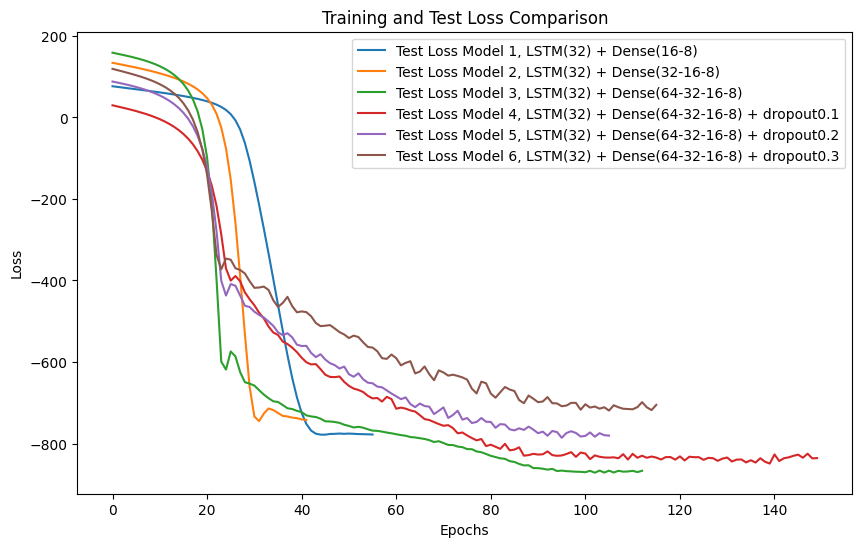

In [16]:
import matplotlib.pyplot as plt


nu = 6.0  # Degrees of freedom
epochs = 500

# Define loss function
criterion = StudentTNegativeLogLikelihood(nu)

plt.figure(figsize=(10, 6))

for name, model in models.items():
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print(f"Training {name}")
    trained_model, train_losses, test_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs)
    models[name] = trained_model
    
    #plt.plot(train_losses, label=f"Train Loss {name}")
    plt.plot(test_losses, label=f"Test Loss {name}")
    
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Comparison")
plt.legend()
plt.show()


In [17]:
import scipy.special as sp
import matplotlib.pyplot as plt

# Function to compute E(|r_t|^c | S_{t-1})
def compute_expectation(h_t, c, nu):
    gamma_v_c = sp.gamma((nu - c) / 2)
    gamma_c_1 = sp.gamma((c + 1) / 2)
    gamma_v = sp.gamma(nu / 2)
    
    factor = (nu - 2) ** (c / 2) * (gamma_v_c * gamma_c_1) / (gamma_v * (np.pi ** 0.5))
    return (h_t ** (c / 2)) * factor

# Function to calculate MSE
def calculate_mse(r_t, expectations, c_values):
    mse_results = {}
    for c in c_values:
        true_values = np.abs(r_t) ** c
        mse = np.mean((true_values - expectations[c]) ** 2)
        mse_results[c] = mse
    return mse_results

def calculate_mae(r_t, expectations, c_values):
    mse_results = {}
    for c in c_values:
        true_values = np.abs(r_t) ** c
        mse = np.mean(np.abs((true_values - expectations[c])))
        mse_results[c] = mse
    return mse_results

# Predict variance h_t using a given model
def predict_variance(model, loader):
    model.eval()
    predicted_h = []

    with torch.no_grad():
        for inputs, _ in loader:
            h_t = model(inputs).squeeze()
            predicted_h.append(h_t)
    
    return torch.cat(predicted_h).cpu().numpy()

Processing Model 1, LSTM(32) + Dense(16-8)...
Processing Model 2, LSTM(32) + Dense(32-16-8)...
Processing Model 3, LSTM(32) + Dense(64-32-16-8)...
Processing Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1...
Processing Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2...
Processing Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3...


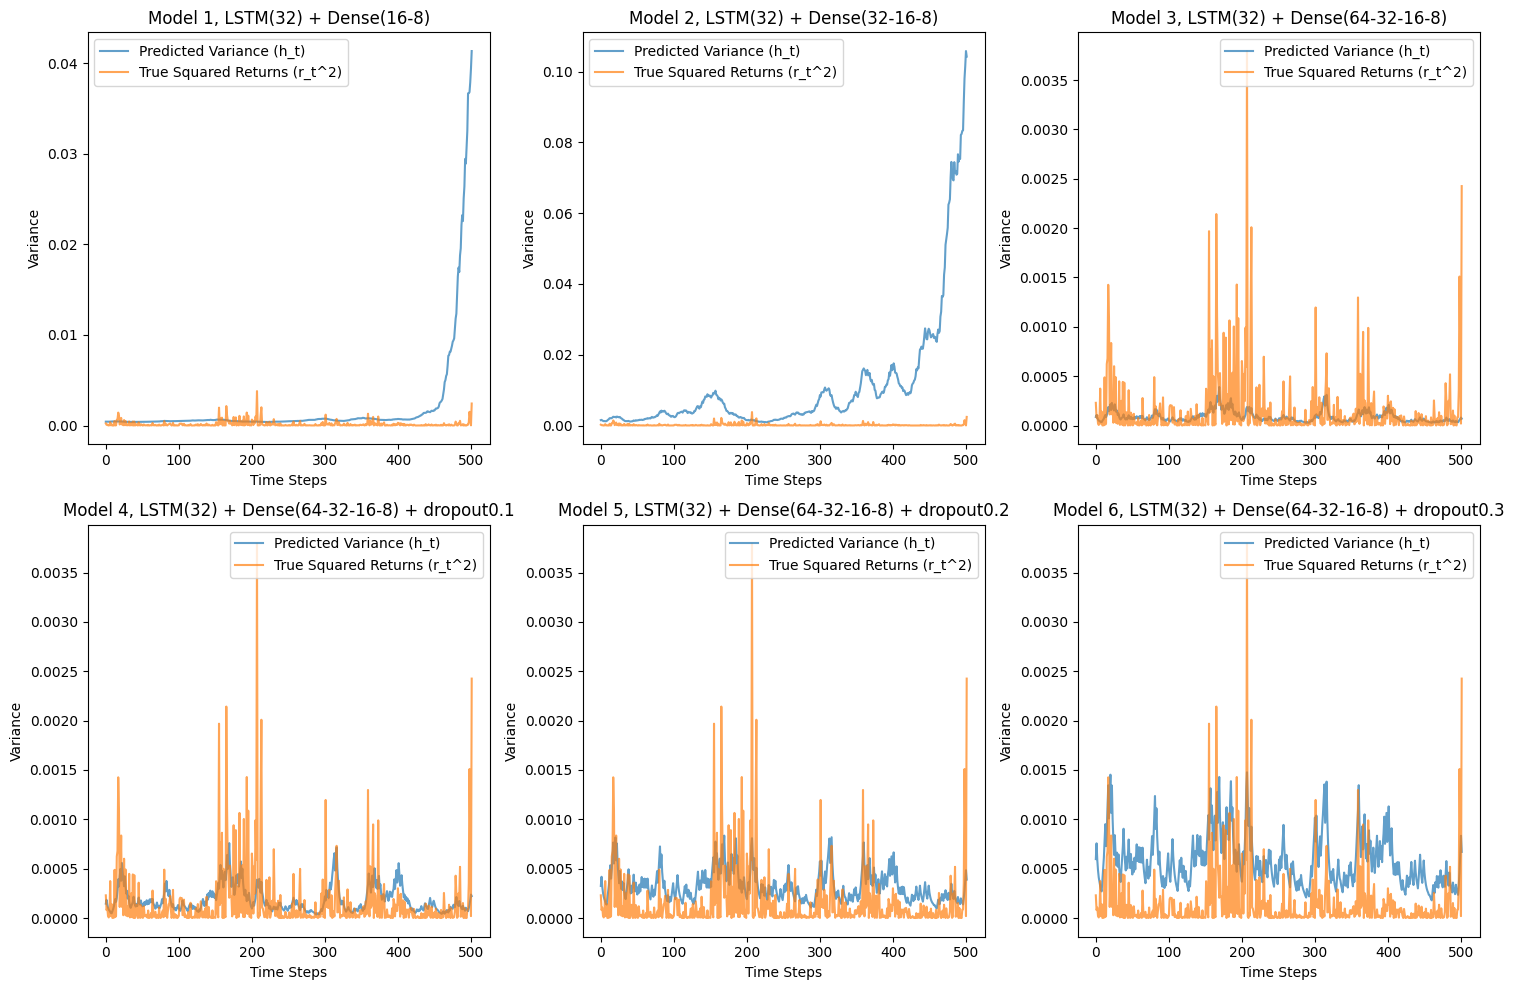


MSE Comparison:

Model 1, LSTM(32) + Dense(16-8):
  MSE for c = 1: 0.0008303330553308142
  MSE for c = 1.5: 0.0001468290750888435
  MSE for c = 2: 3.60723489567789e-05

Model 2, LSTM(32) + Dense(32-16-8):
  MSE for c = 1: 0.005208911317024798
  MSE for c = 1.5: 0.0012764591738105037
  MSE for c = 2: 0.0004393305085227479

Model 3, LSTM(32) + Dense(64-32-16-8):
  MSE for c = 1: 7.214123491753504e-05
  MSE for c = 1.5: 2.712533128967553e-06
  MSE for c = 2: 1.0981946114527486e-07

Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1:
  MSE for c = 1: 6.685108768212728e-05
  MSE for c = 1.5: 2.5286128387304465e-06
  MSE for c = 2: 1.0464909435806565e-07

Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2:
  MSE for c = 1: 8.446185705805456e-05
  MSE for c = 1.5: 3.161900085758833e-06
  MSE for c = 2: 1.2953681753417516e-07

Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3:
  MSE for c = 1: 0.00014426279148729428
  MSE for c = 1.5: 6.274652711335012e-06
  MSE for c = 2: 3.0267733572226545

In [18]:
# Test data squared returns (labels)
r_squared = y_test ** 2  # True squared returns
#print(f"r_squared {r_squared[:5]}")

# c values for MSE calculation
c_values = [1, 1.5, 2]

# Degrees of freedom (nu)
nu = 6.0

mse_results_all = {}
mae_results_all = {}

# Number of models and grid configuration
num_models = len(models)
cols = 3  # Number of columns
rows = (num_models + cols - 1) // cols  # Calculate rows needed

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

for idx, (name, model) in enumerate(models.items()):
    print(f"Processing {name}...")
    
    # Step 1: Predict variance h_t
    predicted_h = predict_variance(model, test_loader)
    
    #print(f"predicted_h {predicted_h[:5]}")
    
    # Step 2: Compute E(|r_t|^c | S_{t-1}) for c = 1, 1.5, 2
    expectations = {c: compute_expectation(predicted_h, c, nu) for c in c_values}
    #print(f"expectations {expectations}")
    #for k in expectations:
        #print(k,expectations[k][:10])
        #print((np.sqrt(r_squared)**k)[:10])
    
    # Step 3: Calculate MSE
    mse_results = calculate_mse(np.sqrt(r_squared), expectations, c_values)
    mae_results = calculate_mae(np.sqrt(r_squared), expectations, c_values)
    mse_results_all[name] = mse_results
    mae_results_all[name] = mae_results
    
    # Step 4: Plot predicted variance vs. true r_t^2
    ax = axes[idx]  # Select subplot axis
    ax.plot(predicted_h, label="Predicted Variance (h_t)", alpha=0.7)
    ax.plot(r_squared, label="True Squared Returns (r_t^2)", alpha=0.7)
    ax.set_title(f"{name}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Variance")
    ax.legend()
    
# Remove unused subplots (if any)
for idx in range(len(models), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.savefig(f"{data_name}_ANN_variance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Print MSE results
print("\nMSE Comparison:")
for name, mse in mse_results_all.items():
    print(f"\n{name}:")
    for c, value in mse.items():
        print(f"  MSE for c = {c}: {value}")
        
# Print MSE results
print("\nMAE Comparison:")
for name, mse in mae_results_all.items():
    print(f"\n{name}:")
    for c, value in mse.items():
        print(f"  MAE for c = {c}: {value}")


In [19]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Train-Test Split
train_returns = y_train  # Training data
test_returns = y_test    # Test data
val_returns = y_val

# Initialize with training data
rolling_train_returns = np.append(train_returns,val_returns).copy()
rolling_train_returns *= 100
predicted_variance = []

for t in range(len(test_returns)):
    # Step 1: Fit GARCH-t(1,1) model to the rolling training data
    garch_t_model = arch_model(rolling_train_returns, vol="Garch", p=1, q=1, dist="t")
    res = garch_t_model.fit(disp="off")
    
    # Step 2: Forecast the next variance (h_t)
    forecast = res.forecast(start=len(rolling_train_returns)-1, horizon=1, reindex=False)
    h_t = forecast.variance.values[-1, 0]  # Forecasted variance
    
    # Step 3: Append the forecasted variance
    predicted_variance.append(h_t/100**2)
    
    # Step 4: Add the current test return to the rolling training set
    rolling_train_returns = np.append(rolling_train_returns, test_returns[t]*100)

# Convert to NumPy array
predicted_variance = np.array(predicted_variance)
garch_predicted_variance = predicted_variance

# Compare Predictions with True Squared Returns (r_t^2)
true_squared_returns = test_returns ** 2  # True squared returns

'''
# Plot Predicted Variance vs True Squared Returns
plt.figure(figsize=(10, 6))
plt.plot(predicted_variance, label="GARCH-t(1,1) Dynamic Predicted Variance")
plt.plot(true_squared_returns, label="True Squared Returns (r_t^2)", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Variance")
plt.title("GARCH-t(1,1) Dynamic Predictions vs. True Squared Returns")
plt.legend()
plt.show()
'''

'\n# Plot Predicted Variance vs True Squared Returns\nplt.figure(figsize=(10, 6))\nplt.plot(predicted_variance, label="GARCH-t(1,1) Dynamic Predicted Variance")\nplt.plot(true_squared_returns, label="True Squared Returns (r_t^2)", alpha=0.7)\nplt.xlabel("Time Steps")\nplt.ylabel("Variance")\nplt.title("GARCH-t(1,1) Dynamic Predictions vs. True Squared Returns")\nplt.legend()\nplt.show()\n'

In [20]:
# Calculate MSE
# Step 1: Predict variance h_t
predicted_h = predicted_variance

# Step 2: Compute E(|r_t|^c | S_{t-1}) for c = 1, 1.5, 2
expectations = {c: compute_expectation(predicted_h, c, nu) for c in c_values}

# Step 3: Calculate MSE
mse_results = calculate_mse(np.sqrt(r_squared), expectations, c_values)
mae_results = calculate_mae(np.sqrt(r_squared), expectations, c_values)
name = "GARCH"
mse_results_all[name] = mse_results
mae_results_all[name] = mae_results


In [21]:
# Initialize with training data
rolling_train_returns = np.append(train_returns,val_returns).copy()
rolling_train_returns *= 100
predicted_variance = []

for t in range(len(test_returns)):
    # Step 1: Fit GARCH-t(1,1) model to the rolling training data
    garch_t_model = arch_model(rolling_train_returns, vol="EGARCH", p=1, q=1, dist="t")
    res = garch_t_model.fit(disp="off")
    
    # Step 2: Forecast the next variance (h_t)
    forecast = res.forecast(start=len(rolling_train_returns)-1, horizon=1, reindex=False)
    h_t = forecast.variance.values[-1, 0]  # Forecasted variance
    
    # Step 3: Append the forecasted variance
    predicted_variance.append(h_t/100**2)
    
    # Step 4: Add the current test return to the rolling training set
    rolling_train_returns = np.append(rolling_train_returns, test_returns[t]*100)

# Convert to NumPy array
predicted_variance = np.array(predicted_variance)
egarch_predicted_variance = predicted_variance

# Compare Predictions with True Squared Returns (r_t^2)
true_squared_returns = test_returns ** 2  # True squared returns

'''
# Plot Predicted Variance vs True Squared Returns
plt.figure(figsize=(10, 6))
plt.plot(predicted_variance, label="EGARCH-t(1,1) Dynamic Predicted Variance")
plt.plot(true_squared_returns, label="True Squared Returns (r_t^2)", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Variance")
plt.title("EGARCH-t(1,1) Dynamic Predictions vs. True Squared Returns")
plt.legend()
plt.show()
'''

# Calculate MSE
# Step 1: Predict variance h_t
predicted_h = predicted_variance

# Step 2: Compute E(|r_t|^c | S_{t-1}) for c = 1, 1.5, 2
expectations = {c: compute_expectation(predicted_h, c, nu) for c in c_values}

# Step 3: Calculate MSE
mse_results = calculate_mse(np.sqrt(r_squared), expectations, c_values)
mae_results = calculate_mae(np.sqrt(r_squared), expectations, c_values)
name = "EGARCH"
mse_results_all[name] = mse_results
mae_results_all[name] = mae_results

In [22]:
# Initialize with training data
rolling_train_returns = np.append(train_returns,val_returns).copy()
rolling_train_returns *= 100
predicted_variance = []

for t in range(len(test_returns)):
    # Step 1: Fit GARCH-t(1,1) model to the rolling training data
    garch_t_model = arch_model(rolling_train_returns, vol="GARCH", p=1, o=1, q=1, dist="t")
    res = garch_t_model.fit(disp="off")
    
    # Step 2: Forecast the next variance (h_t)
    forecast = res.forecast(start=len(rolling_train_returns)-1, horizon=1, reindex=False)
    h_t = forecast.variance.values[-1, 0]  # Forecasted variance
    
    # Step 3: Append the forecasted variance
    predicted_variance.append(h_t/100**2)
    
    # Step 4: Add the current test return to the rolling training set
    rolling_train_returns = np.append(rolling_train_returns, test_returns[t]*100)

# Convert to NumPy array
predicted_variance = np.array(predicted_variance)
gjr_garch_predicted_variance = predicted_variance

# Compare Predictions with True Squared Returns (r_t^2)
true_squared_returns = test_returns ** 2  # True squared returns

'''
# Plot Predicted Variance vs True Squared Returns
plt.figure(figsize=(10, 6))
plt.plot(predicted_variance, label="GJR-GARCH-t(1,1) Dynamic Predicted Variance")
plt.plot(true_squared_returns, label="True Squared Returns (r_t^2)", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Variance")
plt.title("GJR-GARCH-t(1,1) Dynamic Predictions vs. True Squared Returns")
plt.legend()
plt.show()
'''

# Calculate MSE
# Step 1: Predict variance h_t
predicted_h = predicted_variance

# Step 2: Compute E(|r_t|^c | S_{t-1}) for c = 1, 1.5, 2
expectations = {c: compute_expectation(predicted_h, c, nu) for c in c_values}

# Step 3: Calculate MSE
mse_results = calculate_mse(np.sqrt(r_squared), expectations, c_values)
mae_results = calculate_mae(np.sqrt(r_squared), expectations, c_values)
name = "GJR-GARCH"
mse_results_all[name] = mse_results
mae_results_all[name] = mae_results

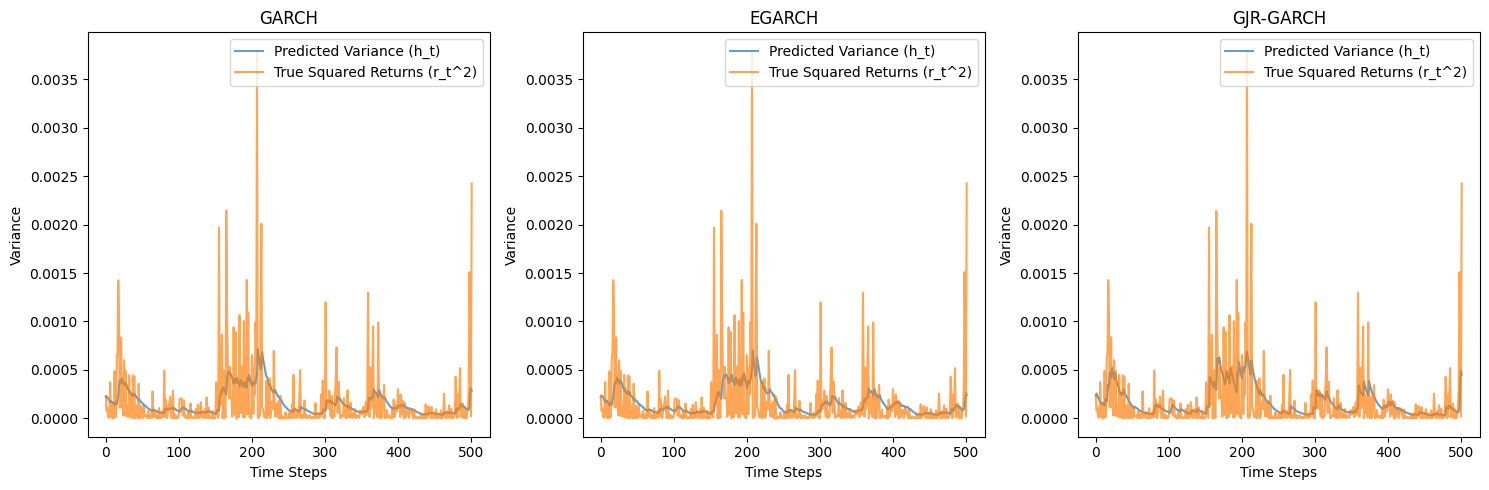

In [23]:
rows = 1
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

garch_vars = {"GARCH": garch_predicted_variance, "EGARCH": egarch_predicted_variance, "GJR-GARCH": gjr_garch_predicted_variance}
for idx, (name, value) in enumerate(garch_vars.items()):
    ax = axes[idx]  # Select subplot axis
    ax.plot(value, label="Predicted Variance (h_t)", alpha=0.7)
    ax.plot(r_squared, label="True Squared Returns (r_t^2)", alpha=0.7)
    ax.set_title(f"{name}")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Variance")
    ax.legend()
    
# Adjust layout
plt.tight_layout()
plt.savefig(f"{data_name}_GARCH_variance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
mse_df = pd.DataFrame(mse_results_all).T
mae_df = pd.DataFrame(mae_results_all).T

In [25]:
pd.set_option('display.float_format', '{:.10f}'.format)
mse_df

,1.0000000000,1.5000000000,2.0000000000
"Model 1, LSTM(32) + Dense(16-8)",0.0008303331,0.0001468291,0.0000360723
"Model 2, LSTM(32) + Dense(32-16-8)",0.0052089113,0.0012764592,0.0004393305
"Model 3, LSTM(32) + Dense(64-32-16-8)",0.0000721412,0.0000027125,0.0000001098
"Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1",0.0000668511,0.0000025286,0.0000001046
"Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2",0.0000844619,0.0000031619,0.0000001295
"Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3",0.0001442628,0.0000062747,0.0000003027
GARCH,0.0000680273,0.0000025578,0.0000001048
EGARCH,0.0000689706,0.0000025849,0.0000001054
GJR-GARCH,0.0000637561,0.0000023847,0.0000000976


In [26]:
mae_df

,1.0000000000,1.5000000000,2.0000000000
"Model 1, LSTM(32) + Dense(16-8)",0.0179990088,0.0053532830,0.0019351681
"Model 2, LSTM(32) + Dense(32-16-8)",0.0566689694,0.0231864269,0.0109249116
"Model 3, LSTM(32) + Dense(64-32-16-8)",0.0057135328,0.0008941600,0.0001425913
"Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1",0.0060953114,0.0010409288,0.0001826452
"Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2",0.0076619915,0.0014259245,0.0002715457
"Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3",0.0106807325,0.0022425820,0.0004832898
GARCH,0.0060447934,0.0009970688,0.0001700205
EGARCH,0.0060908244,0.0010037301,0.0001711576
GJR-GARCH,0.0059027940,0.0009738812,0.0001671626


In [27]:
print(mae_df.to_csv())

,1.0,1.5,2.0
"Model 1, LSTM(32) + Dense(16-8)",0.017999008842488947,0.0053532830121886575,0.0019351680694612511
"Model 2, LSTM(32) + Dense(32-16-8)",0.05666896935711334,0.023186426908107984,0.0109249115507072
"Model 3, LSTM(32) + Dense(64-32-16-8)",0.005713532762940811,0.0008941600498420085,0.00014259127337796392
"Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1",0.006095311380827348,0.0010409287810126482,0.0001826451872695694
"Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2",0.0076619915052605165,0.0014259244842943653,0.0002715457356467208
"Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3",0.010680732474074115,0.002242582047959736,0.00048328983380444153
GARCH,0.006044793419429201,0.0009970687633011,0.00017002050458476766
EGARCH,0.006090824388983506,0.0010037301006641476,0.00017115759858680365
GJR-GARCH,0.0059027940357468224,0.0009738812042687054,0.00016716264431294745



In [28]:
print(mse_df.to_csv())

,1.0,1.5,2.0
"Model 1, LSTM(32) + Dense(16-8)",0.0008303330553308142,0.0001468290750888435,3.60723489567789e-05
"Model 2, LSTM(32) + Dense(32-16-8)",0.005208911317024798,0.0012764591738105037,0.0004393305085227479
"Model 3, LSTM(32) + Dense(64-32-16-8)",7.214123491753504e-05,2.712533128967553e-06,1.0981946114527486e-07
"Model 4, LSTM(32) + Dense(64-32-16-8) + dropout0.1",6.685108768212728e-05,2.5286128387304465e-06,1.0464909435806565e-07
"Model 5, LSTM(32) + Dense(64-32-16-8) + dropout0.2",8.446185705805456e-05,3.161900085758833e-06,1.2953681753417516e-07
"Model 6, LSTM(32) + Dense(64-32-16-8) + dropout0.3",0.00014426279148729428,6.274652711335012e-06,3.0267733572226545e-07
GARCH,6.80272964723531e-05,2.557836796525518e-06,1.0478504643402538e-07
EGARCH,6.897055440392e-05,2.584929070095532e-06,1.0535089351412613e-07
GJR-GARCH,6.375610304458806e-05,2.3847495615204474e-06,9.757332156226783e-08

